Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15976911.88it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 460061.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4409638.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2158700.14it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Step 0, Loss: 0.12170951068401337
Step 500, Loss: 0.04519600048661232
Step 1000, Loss: 0.010154466144740582
Step 1500, Loss: 0.004544754512608051
Step 2000, Loss: 0.002687336876988411
Step 2500, Loss: 0.0026970200706273317
Step 3000, Loss: 0.0015757522778585553


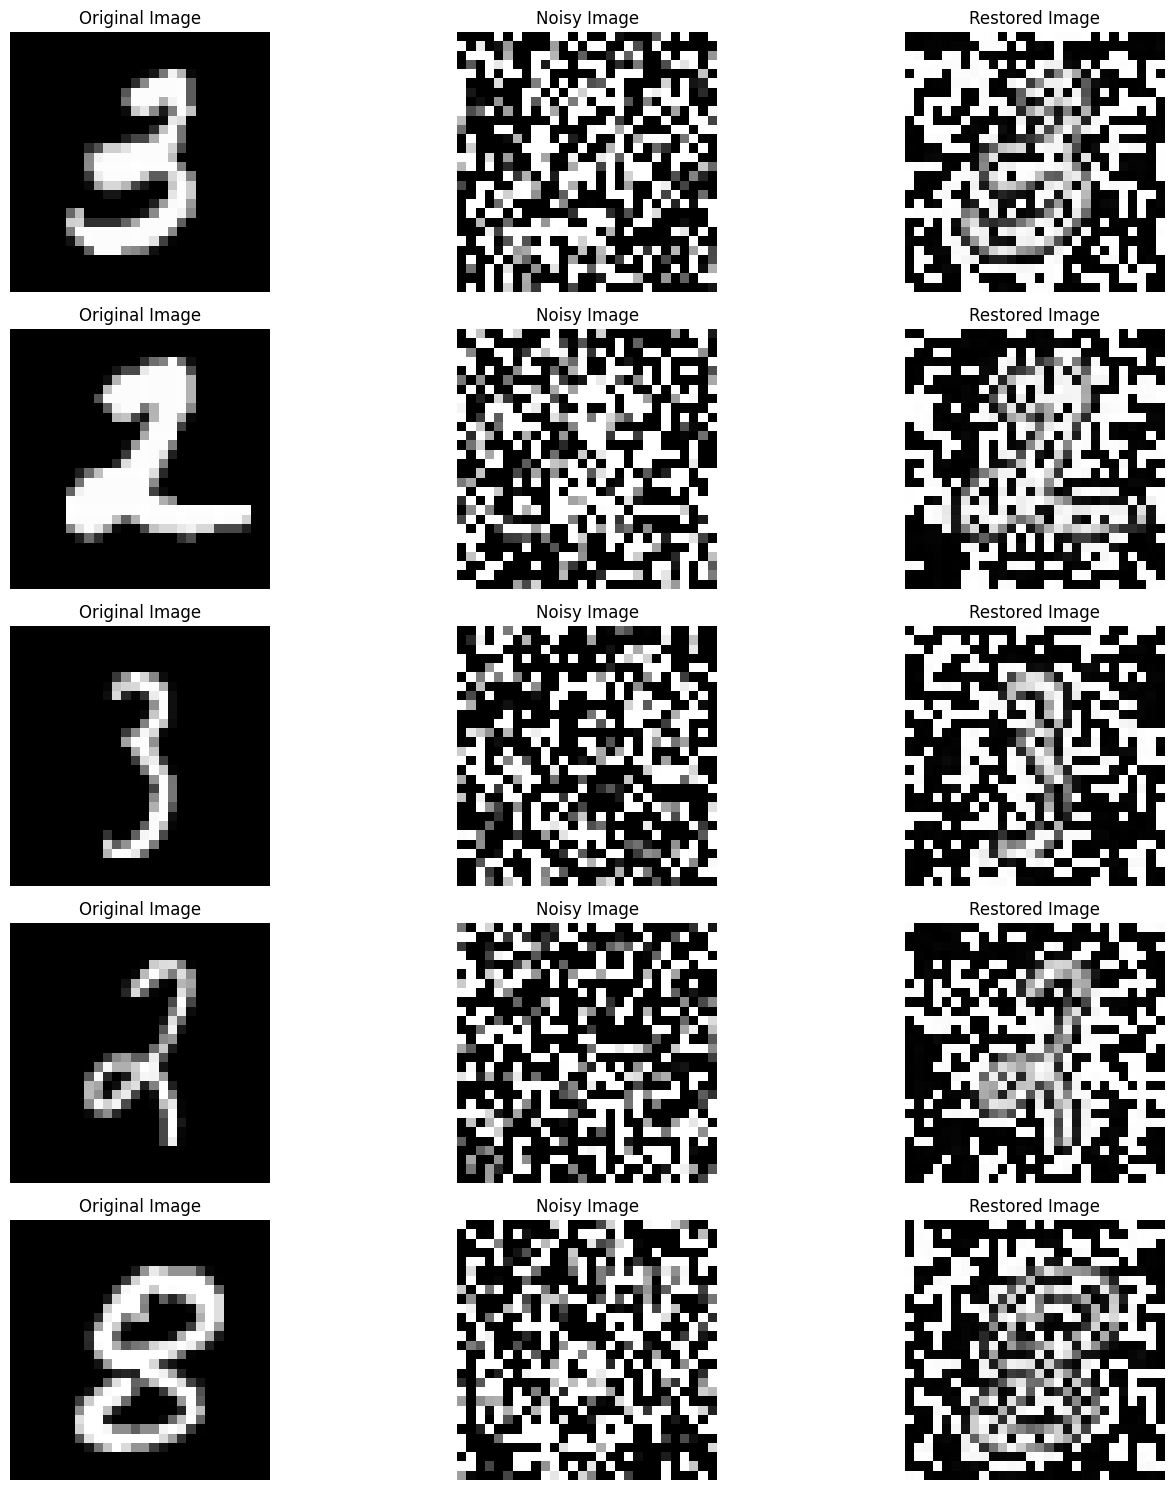

Batch 1:
Restored Images Shape: torch.Size([128, 1, 28, 28])
Labels Shape: torch.Size([128])


In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, ToPILImage
import torch.utils.data as data

# 定义DIPNet模型
class DIPNet(nn.Module):
    def __init__(self):
        super(DIPNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        return x

# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 加载一个批次的MNIST图像
batch_size = 128
mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
images, _ = next(iter(mnist_loader))

# 定义添加高斯噪声的函数
def add_gaussian_noise(image, mean=0, std=2):
    noise = torch.randn_like(image) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clip(noisy_image, 0., 1.)  # 确保值在[0, 1]范围内
    return noisy_image

# 定义训练DIP模型的函数
def train_dip_batch(noisy_images, target_images, num_steps=3500, lr=0.0005):
    net = DIPNet().cuda()
    noisy_images = noisy_images.cuda()
    target_images = target_images.cuda()
    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    
    for step in range(num_steps):
        optimizer.zero_grad()
        out = net(noisy_images)
        loss = mse_loss(out, target_images)
        loss.backward()
        optimizer.step()
        
        if step % 500 == 0:
            print(f"Step {step}, Loss: {loss.item()}")
    
    return net, out

# 定义显示图像的函数
def display_images_batch(original, noisy, restored, num_images=5):
    original = original.cpu()
    noisy = noisy.cpu()
    restored = restored.cpu()
    
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images*3))
    
    for i in range(num_images):
        axes[i, 0].imshow(ToPILImage()(original[i]), cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(ToPILImage()(noisy[i]), cmap='gray')
        axes[i, 1].set_title('Noisy Image')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(ToPILImage()(restored[i]), cmap='gray')
        axes[i, 2].set_title('Restored Image')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 添加高斯噪声到图像
noisy_images = add_gaussian_noise(images)

# 训练DIP模型
dip_model, restored_images = train_dip_batch(noisy_images, images)

# 显示原始、噪声和修复后的图像
display_images_batch(images, noisy_images, restored_images, num_images=5)

# 保存训练好的DIP模型
torch.save(dip_model.state_dict(), 'dip_model.pth')

# 定义函数：使用训练好的DIP模型处理整个MNIST数据集
def process_full_mnist_with_dip(dip_model, mnist_loader, device='cuda'):
    dip_model.eval()  # 设置模型为评估模式
    all_restored_images = []
    all_labels = []
    
    with torch.no_grad():  # 禁用梯度计算
        for images, labels in mnist_loader:
            images = images.to(device)
            restored_images = dip_model(images)
            all_restored_images.append(restored_images.cpu())
            all_labels.append(labels)
    
    all_restored_images = torch.cat(all_restored_images)
    all_labels = torch.cat(all_labels)
    
    return all_restored_images, all_labels

# 使用训练好的DIP模型处理整个MNIST数据集
trained_dip_model = DIPNet().cuda()
trained_dip_model.load_state_dict(torch.load('dip_model.pth'))  # 加载模型权重

mnist_loader_full = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=False)
restored_images, labels = process_full_mnist_with_dip(trained_dip_model, mnist_loader_full)

# 创建一个新的 TensorDataset，包含修复的图像和原始的标签
restored_dataset = data.TensorDataset(restored_images, labels)

# 创建一个新的 DataLoader
restored_loader = data.DataLoader(restored_dataset, batch_size=batch_size, shuffle=False)

# 测试新的 DataLoader
for i, (restored_batch, labels_batch) in enumerate(restored_loader):
    print(f"Batch {i + 1}:")
    print("Restored Images Shape:", restored_batch.shape)
    print("Labels Shape:", labels_batch.shape)
    break  # 只打印第一个批次
